In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torchvision.transforms import ToTensor
from torchvision.datasets import MNIST
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from torch import optim
from time import time
from torch.utils.tensorboard import SummaryWriter
%load_ext tensorboard

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [ ]:
t1 = time() 
BATCH_SIZE = 32

train_data = torchvision.datasets.MNIST(root='mnist-data', download=True,
                                        train=True, transform=ToTensor())
test_data = torchvision.datasets.MNIST(root='mnist-data', download=True,
                                       train=False, transform=ToTensor())



In [ ]:
class CNN(nn.Module):
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 4, 1)
        self.relu = nn.ReLU()
        self.flatten = nn.Flatten(start_dim=1)
        self.conv2 = nn.Conv2d(6, 12, 4, 1)
        self.pool1 = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(12*4*4, 128)
        self.fc2 = nn.Linear(128, 10)

    def forward(self, x):
        softmax = nn.Softmax(dim=1)
        x = self.pool1(self.relu(self.conv1(x)))
        x = self.pool1(self.relu(self.conv2(x)))
        x = self.flatten(x)
        x = self.relu(self.fc1(x))
        x = self.fc2(x)
        return softmax(x)

In [ ]:

device = 'cuda' if torch.cuda.is_available() else 'cpu'

model = CNN()
model = model.to(device)

cel = nn.CrossEntropyLoss()
#writer = SummaryWriter(f'/content/runs/mnist-data/MNIST/trying_tensorboard')

In [ ]:
def validate(model, data, device='cpu'):
    correct = 0
    total = 0
    for i, (images, labels) in enumerate(data):
        with torch.no_grad():
            images = images.to(device)
            labels = labels.to(device)
            output = model(images)
            value, pred = torch.max(output, 1)
            total += output.shape[0]
            correct += torch.sum(pred == labels)
    return (correct / total) * 100

In [ ]:
def train(model, epochs=5, device='cpu'):
    losses = []
    accuracies = []
    
    LR = [0.001, 1e-3]
    batch_sizes = [32, 64]
    for lr in LR:
        for batch_size in batch_sizes:
            step = 0
            writer = SummaryWriter(f'/content/runs/mnist-data/MNIST/batch size {batch_size} learning rate {lr}')
            optimizer = optim.Adam(model.parameters(), lr=lr)
            train_dl = DataLoader(train_data, batch_size=batch_size, shuffle=True)
            test_dl = DataLoader(test_data, batch_size=batch_size, shuffle=True)
            for e in range(epochs):
                correct = 0
                total = 0
                for i, (images, labels) in enumerate(train_dl):
                    images, labels = images.to(device), labels.to(device)
                    output = model(images)
                    optimizer.zero_grad()
                    loss = cel(output, labels)
                    losses.append(loss.item())
                    loss.backward()
                    optimizer.step()
                    value, pred = torch.max(output, 1)
                    total += output.shape[0]
                    correct += torch.sum(pred == labels)
                    train_accuracy = (correct / total) * 100
                    writer.add_scalar('Training Loss', loss, global_step = step)
                    writer.add_scalar('Training accuracy', train_accuracy, global_step = step)
                    step += 1
                val_accuracy = float(validate(model, test_dl, device='cuda'))
                accuracies.append(val_accuracy)
                print(f'Epoch {e}, the accuracy is {val_accuracy}')


In [ ]:
train(model, epochs=1, device='cuda')

Epoch 0, the accuracy is 96.01637268066406
Epoch 0, the accuracy is 193.71018981933594
Epoch 0, the accuracy is 97.19448852539062
Epoch 0, the accuracy is 194.6457061767578


In [ ]:
%tensorboard --logdir runs

In [ ]:
def visualize(model, data, device='cpu'):
    with torch.no_grad():
        data = data[np.random.randint(0, 100, 1)[0]][0]
        data = data.unsqueeze(0)
        data = data.to(device)
        output = model(data)
        output = output.to('cpu')
        data = data.to('cpu')
        values, idx = torch.topk(output, 5)
        plt.imshow(data.view(28, 28), cmap='gray')
        plt.show()
        plt.bar(idx.flatten(), values.flatten())
        plt.show()

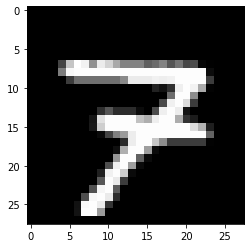

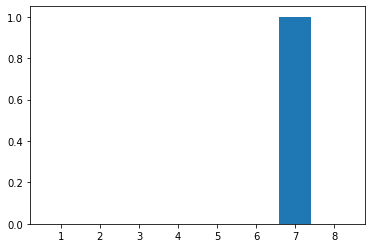

the time it took for this code to execute is 56.907559871673584


In [ ]:
visualize(model, test_data, device='cuda')
print(f'the time it took for this code to execute is {time() - t1}')